# <center>Parte 4:</center>
---
Realiza una MCA entre la matriz de extremos anómala y la matriz de SLP o SST.

In [1]:
import numpy as np
from numpy.linalg import inv
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
from scipy import signal
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

C:\Users\usuario\AppData\Local\Temp\ipykernel_1836\670476320.py:7: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


## Funciones

In [2]:
def region(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc

def season(Z,e1,e2,nyrs):
# para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
# e1 y e2 son los meses inicial y final de las estaciones
# e1=2;e2=4 ;esta='MAM';
# e1=5;e2=7 ;esta='JJA';
# e1=6;e2=8 ;esta='JAS';
# e1=8;e2=10 ;esta='SON';
# e1=11;e2=1 ;esta='DJF';
# e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

def anom(X,nyr,par):
#si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns,nt=np.shape(X) #una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes=np.int(nt/(nyr));
    #nmes=1
#dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
#anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An=ma.empty([ns,nt])

    for i in range(ns):
        A= X[i,:].reshape(nyr,nmes)
        mA=np.mean(A)
        for j in range(0,nyr):
            A[j,:]=A[j,:]-mA
        
        if  par=='st':
            
            stdA=ma.empty([nmes,])
            for k in range(nmes):
                stdA[k]=np.std(A[:,k])
                if stdA[k]!=0:
                    A[:,k]=A[:,k]/stdA[k]
    

#se reorganizan los datos
        A=np.transpose(A.reshape(nyr*nmes,1))
        An[i,:]=A;
              
    return An

In [3]:
def dibujo_1_mapa_cartopy(A,lon,lat, levs, cmap1, l1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))

    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon))
                 ,cmap=cmap1,levels=levs,extend='both',transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    
# Esta función te sirve para dibujar en una misma figura dos mapas superpuestos, como podría ser
# el caso de un mapa A de regresion y un mapa B de correlacion significativa, del que solo te interesa
# las regiones donde es significativa la señal
def dibujo_2_mapas_cartopy_hatches(A,B,lon,lat, levs, cmap1, l1, t1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
    
    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon)), 
                     extend='both',cmap=cmap1,levels=levs,transform = ccrs.PlateCarree())

    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    im = ax.contourf(lon,lat,B.reshape(len(lat),len(lon))
                 ,extend='both'
                 ,hatches='.',cmap=cmap1,alfa=0,levels=levs,transform = ccrs.PlateCarree())
    #el uso de alfa=0 lo que hace es que solo salgan los puntos y no salgan los colors porque los pones totalmente transparentes
    # si el mapa significativo abarca una región menor suele cortarlo
    # para ello añadimos estos límites
    ax.set_ylim(lat[-1], lat[0])
    ax.set_xlim(lon[0], lon[-1])

In [4]:
# Esta función calcula correlaciones en datos de mas de una dimensión
# util en indexredrcorr
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

In [5]:
# misma que index regresión pero algo mas intuitiva
def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)

    # MUY IMPORTANTE!!!
    # Index tiene que ser una serie de datos estandarizada
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor, Pvalue, cor_sig, reg,reg_sig

    # correlacion y regresion significativo son mapas con un p value
    # menor al impuesto por nosotros
    # cuando es mayor no los enseñara y los hará mascara

In [6]:
# para operar con nans
def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

In [7]:
def MCA(Z,Y,nmes,nm,meth,alfa,sig,perm):
    # Z: campo a predecir
    # Y: campo predictor
    # datos con dimensiones ns, nt
    # nm: numero de modos
    # nmes: meses por año, si es media estacional es 1, pero si es enero y feb
    # por separado es 2
    # meth: metodología
    # Y1, Z1: campos sobre los que proyecto los resultados, 
    #que pueden ser para un espacio mayor que en Z e Y
    
    nz,nt=Z.shape
    ny,nt=Y.shape
    nyr=int(nt/nmes)
    # matriz de covarianza
    if  meth=='MCA':
        C=np.dot(Y,np.transpose(Z))
    
    if  meth =='CCA': # matriz de covarianza
        iSYY=inv(np.dot(Y,np.transpose(Y)))
        SYZ=np.dot(Y,np.transpose(Z))
        iSZZ=inv(np.dot(Z,np.transpose(Z)))
        SZY=np.dot(Z,np.transpose(Y))
        C=np.dot(np.dot(iSYY,SYZ), np.dot(iSZZ,SZY))
    
    R,d,Q=linalg.svd(C)
    scf=d/np.sum(d) # fraccion de covarianza explicada

    # coefs de expansión, protectamos sobre los primeros nm 
    # obtenemos unas series temporales
    U=np.dot(np.transpose(Y),R[:,:nm])
    V=np.dot(np.transpose(Z),Q[:,:nm])
    
    # coefs de expansión estandarizados
    # estandarizamos esas series temporales
    Us = anom(np.transpose(U),nyr,'st')
    Vs = anom(np.transpose(V),nyr,'st')
    
    # mapas de regresión en ambos casos se usa U y no V !! (serie temporal U)
    RUY = ma.empty([ny,nm]);pvalruy=ma.empty([ny,nm]);RUY_sig=ma.empty([ny,nm]);SUY=ma.empty([ny,nm]);SUY_sig=ma.empty([ny,nm])
    RUZ = ma.empty([nz,nm]);pvalruz=ma.empty([nz,nm]);RUZ_sig=ma.empty([nz,nm]);SUZ=ma.empty([nz,nm]);SUZ_sig=ma.empty([nz,nm])
    
    # proyrctamos los datos sobre los primeros nm autovalores
    for i in range(nm):
        RUY[:,i], pvalruy[:,i], RUY_sig[:,i], SUY[:,i], SUY_sig[:,i]=IndexRegrCorr(Y,Us[i,:],alfa,sig,perm)
        RUZ[:,i], pvalruz[:,i], RUZ_sig[:,i], SUZ[:,i], SUZ_sig[:,i]=IndexRegrCorr(Z,Us[i,:],alfa,sig,perm)
    
    # MAPA DE CORRELACION SOBRE Y Y Z
    return RUY, RUY_sig, SUY, SUY_sig, RUZ, RUZ_sig, SUZ, SUZ_sig, Us, Vs, scf


In [8]:
def filtro(nyc,n,Wn,TS):
    '''
    nyc: periodo
    n  :
    wn : frecuencia de corte 2*dt/nyc
    TS :
    '''
# Wn= 
    b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
    # Filtro la señal ampliada y me quedo con la parte central:
    low = signal.filtfilt(b,a,TS)
    b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
    # Filtro la señal ampliada y me quedo con la parte central:
    high = signal.filtfilt(b,a,TS)
    return high, low

In [9]:
def dibujo_timeserie(ax,TS,time,ylabel,xlabel,title):
    '''
    '''
    ax.plot(time,TS,linewidth=6)
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    # ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold')

In [10]:
def dibujo_timeserie_confiltro(ax,time,sig,low,low_det,high,xlabel,ylabel,title):
    ax.plot(time,sig,label ='raw')
    ax.plot(time,low,label ='low')
    ax.plot(time,high,label ='high')
    ax.plot(time,low_det,label ='low_det')
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold')

In [11]:
def crossvalidation(Y,Z,nmes,nm,alfa,sig,perm):
    '''
    Técnica utilizada para predicción que se explicará más adelantes
    '''
    #Y campo predictor
    # Z campo a predecir
    # nmes: numero de tiempos por año (numero de meses o de días), normalmente es 1 porque se hacen promedios estacionales
    # alfa: nivel de significacion: 0.01,0.05,0.1
    #sig: "t-test" si la significacion de los modos se hace por un test de independencia de caracteres con test-t, "MonteCarlo", 
    #si se hace con un test no paramétrico de MonteCarlo con un número perm de permutaciones (100, 200 etc..)
    
    nz,nt = Z.shape
    ny,nt = Y.shape
    
    Zhat = ma.empty_like(Z)
    scf = ma.empty([ny,nt])
    ruv = ma.empty([nm,nt])
    pruv = ma.empty([nm,nt])
    # estimación de Zhat para cada año
    yrs=np.linspace(1,nt,nt)
    for i in range(nt):
        print(i)
        z2 = Z[:,yrs!=i]
        y2 = Y[:,yrs!=i]
        RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf[:,i] = MCA(z2,y2,nmes,nm,'MCA',alfa,sig,perm)
        PSI=np.dot(np.dot(np.dot(SUY,linalg.inv(np.dot(Us,np.transpose(Us)))),Us),np.transpose(z2))*nt*nm/ny 
        Zhat[:,i] = np.dot(np.transpose(Y[:,i]),PSI)
        for m in range(nm):
            ruv[m,i],pruv[m,i] = pearsonr(Us[m,:],Vs[m,:])
    
    r = np.zeros(nt)       
    for j in range(nt):
        r[j] = pearsonr(Zhat[:,j],Z[:,j])[0] # serie de skill
      
    rs = np.zeros(nz) 
    rs_sig = np.zeros(nz) 
    rmse = np.zeros(nz)
  
    for j in range(nz):
        rs[j] = pearsonr(Zhat[:,j],Z[:,j])[0] # serie de skill
  
        
    return Zhat,scf,ruv,r

## Campo a Predecir: Cold Nights

In [12]:
# matriz de extremos anomala (campo a predecir Z) -  cold nights
folder = 'data/Tn10p_ESP_nan.nc'
ds     = xr.open_dataset(folder)

# elijo los años 
ds = ds.sel(time=slice('1901', '2010'))

# selecciono la latitud y longitud
lon = ds.x
lat = ds.y

# aqui tengo los datos de cold nights
variable = ds.__xarray_dataarray_variable__

# remallado de los datos 
tn10_remallado = variable.interp(lat=variable.lat[::2]).interp(lon=variable.lon[::2])
tn10_remallado = tn10_remallado.set_index(lon='x')
tn10_remallado = tn10_remallado.set_index(lat='y')

In [13]:
# ahora las latitudes y longitudes tienen diferente dimension
lat = variable.lat[::2]
lon = variable.lon[::2]

In [14]:
lonmin_z, lonmax_z, latmin_z, latmax_z = lon.min(), lon.max(), lat.min(), lat.max()

In [15]:
# eleccion de la region
tn10_remallado, lat_z, lon_z = region(tn10_remallado, lat, lon, lonmin_z, lonmax_z, latmin_z, latmax_z)

In [16]:
lat_z = tn10_remallado.lat
lon_z = tn10_remallado.lon

In [17]:
# reshape y selección de la season
tn10_reshape = np.reshape(tn10_remallado, (110, 12, len(lon_z)*len(lat_z)))

# selecciono primavera ya que fue donde mas variabilidad encontramos
tn10_primavera = tn10_reshape[:, 2:4, :].mean('lat')
# lo convierto en numpy array para que no me vuelva a dar problemas 
# con lo del index
tn10_primavera = np.asarray(tn10_primavera)

# calculo las anomalias
tn10_anom = anom(np.transpose(tn10_primavera), 110, 'pp')

### Campo Predictor: *SLP*

In [18]:
# campo predictor SLP campo Y
folder_1 = '..\..\data\ERA\slp_ERA20_1900-2010.nc'
ds_y     = xr.open_dataset(folder_1)
ds_y = ds_y.sel(time=slice('1901', '2010'))

In [19]:
# guardo las variables de sea level preassure
msl   = ds_y.msl
lat_y = ds_y.latitude
lon_y = ds_y.longitude
date  = ds_y.time

# como tengo datos mensuales
n_years = int(len(date)/12)

# como la longitud va de -180 a 180:
lon_y = lon_y - 180.
msl   = np.roll(msl, int(len(lon_y)/2))

In [20]:
# elijo una region especifica por ahora la que belen elige
lonmin  , lonmax  , latmin  , latmax   = -50, 10, 20, 80
lonmin_1, lonmax_1, latmin_1, latmax_1 = -270, -70, -20, 20

In [21]:
# pongo los años de mi campo predictor y a predecir en común
# ambos van desde 1900, 2010 miremos a ver si sus tiempos 
# tienen la misma longitud

len(ds.time), len(ds_y.time)

(1320, 1320)

In [22]:
# eleccion de la region
msl, lat_y, lon_y = region(msl, lat_y, lon_y, lonmin, lonmax, latmin, latmax)

In [24]:
# debo calcular las anomalias
msl_reshaped          = np.reshape(msl, (n_years, 12, len(lon_y)*len(lat_y)))
msl_primavera, nyprim = season(np.transpose(msl_reshaped), 2, 4, n_years)
msl_primavera_anom    = anom(np.transpose(msl_primavera), 1, 'pp')

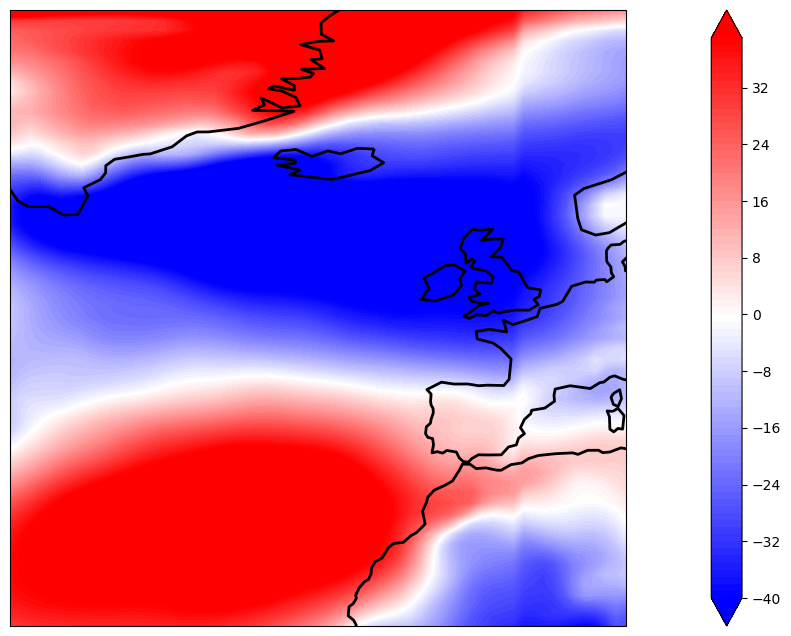

In [59]:
# dibujo de la slp un año en concreto
# tengo tiempo, espacio
slp_1998 = msl_primavera_anom[0, :]

# plot
fig = plt.figure(figsize=(22, 8))
dibujo_1_mapa_cartopy(slp_1998/10, lon_y, lat_y, np.arange(-40, 40), 'bwr', '')

### MCA

In [60]:
# elección de años comunes
yrs = list(range(1901, 2011)) # len(yrs) = 111

# nose porque se hace esto
nmes = 1

# cambio los nans por numeros
z = np.nan_to_num(tn10_anom,          nan = -999)
y = np.nan_to_num(msl_primavera_anom, nan = -999)
y = np.transpose(y)

In [61]:
# cálculo de la mca
RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf=MCA(z.data,y.data,nmes,3,'MCA',0.1,'MonteCarlo',100)

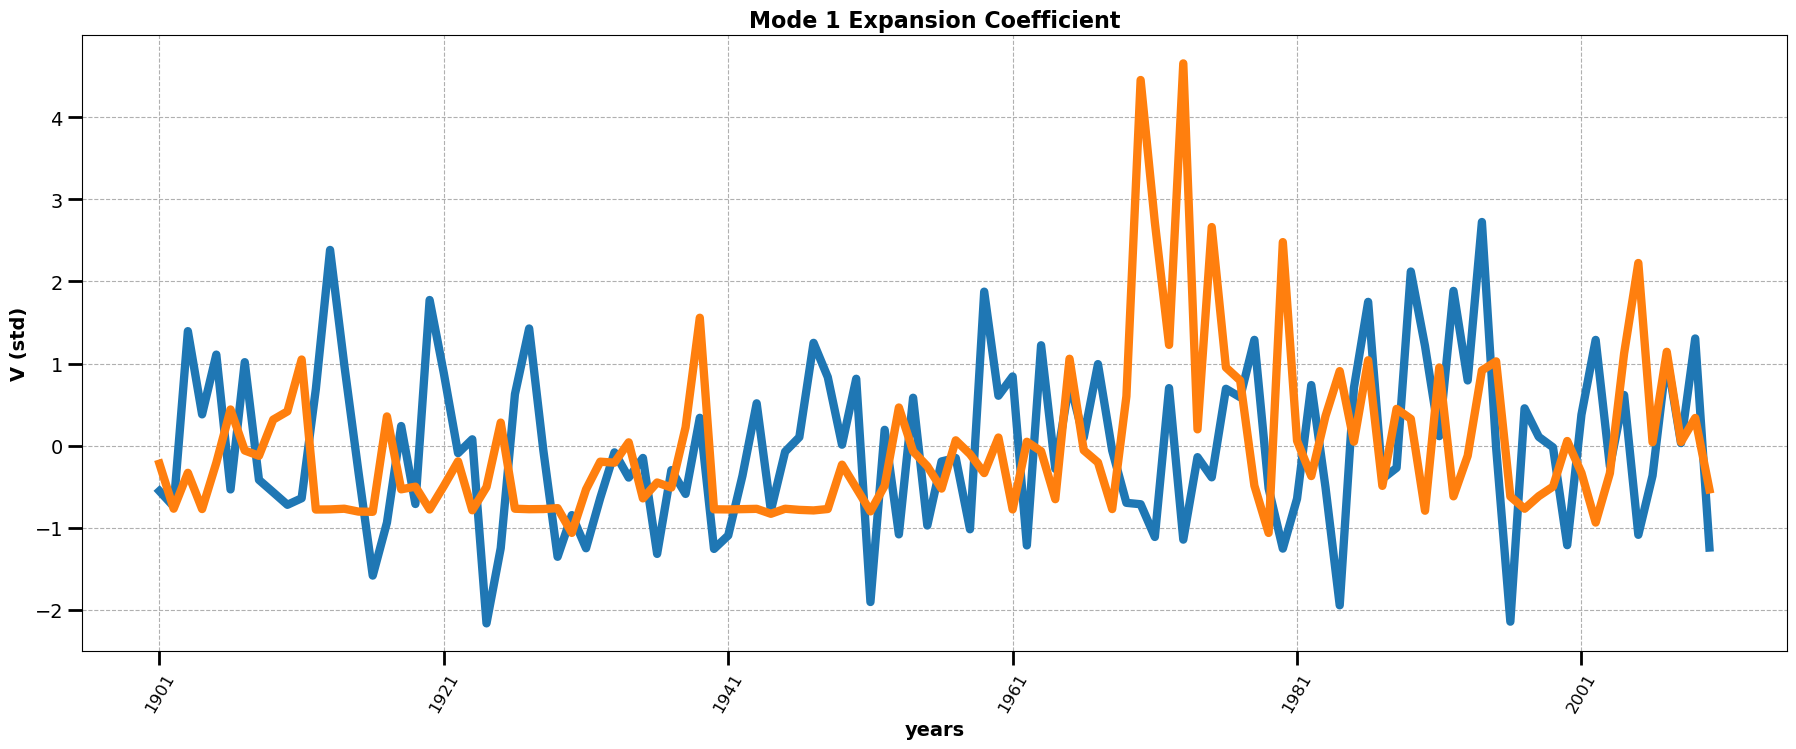

In [62]:
fig = plt.figure(figsize=(22,8)) 
ax=fig.add_subplot(1, 1, 1)
dibujo_timeserie(ax,Us[0,:],yrs,'U (std)','years','Mode 1 Expansion Coefficient')
dibujo_timeserie(ax,Vs[0,:],yrs,'V (std)','years','Mode 1 Expansion Coefficient')

#### Filtro

In [63]:
r=pearsonr(np.transpose(Us[0,:]),np.transpose(Vs[0,:]))

# aplicamos un filtro
high,low=filtro(7,10,2/7,Us[1,:])

Usd=signal.detrend(Us[1,:])

np.save('Leading_mode_SST_SLP_sep', Usd)

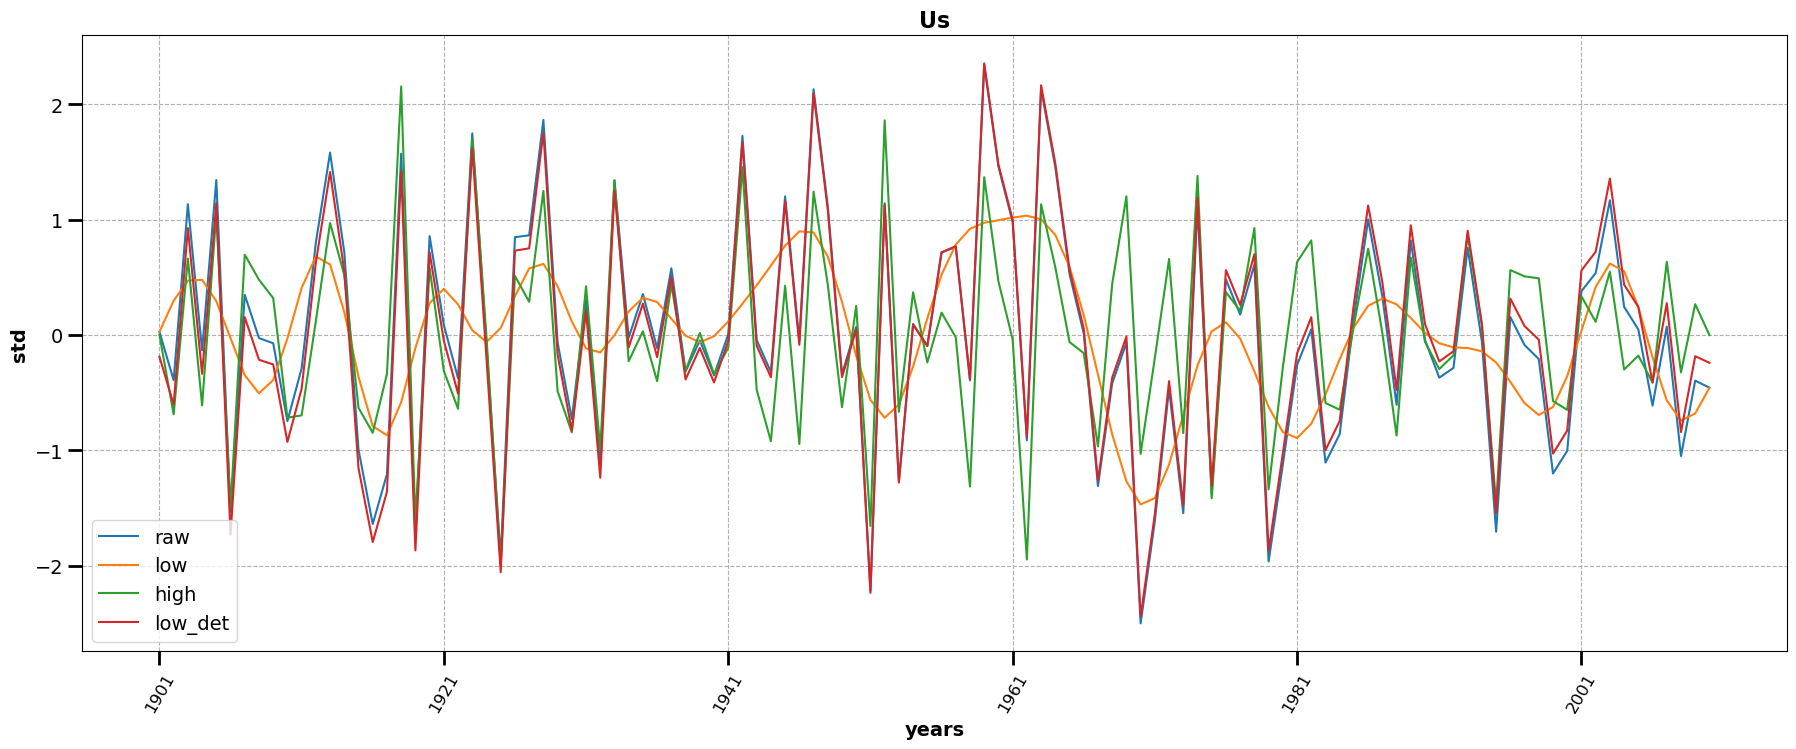

In [64]:
# dibujamos el filtro aplicado al segundo modo
fig = plt.figure(figsize=(22,8)) 
ax=fig.add_subplot(1, 1, 1)
dibujo_timeserie_confiltro(ax,yrs,Us[1,:],low,Usd,high,'years','std','Us')

In [73]:
modo = 1

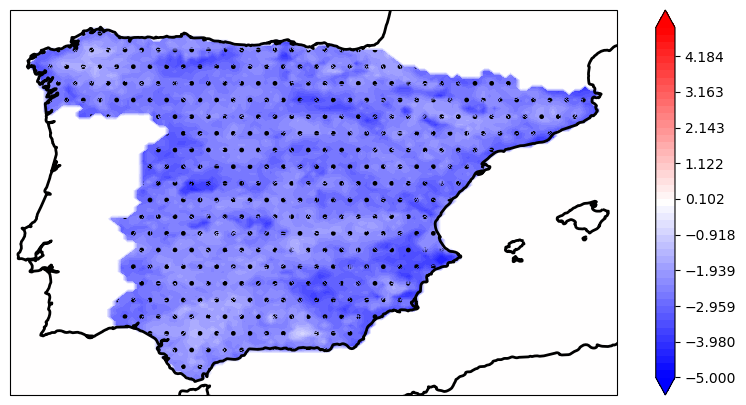

In [74]:
fig = plt.figure(figsize=(10,5)) 
dibujo_2_mapas_cartopy_hatches(SUZ[:,modo],SUZ_sig[:,modo],lon_z,lat_z,np.linspace(-5,5,50),'bwr', '','')
# suz, suz_sig

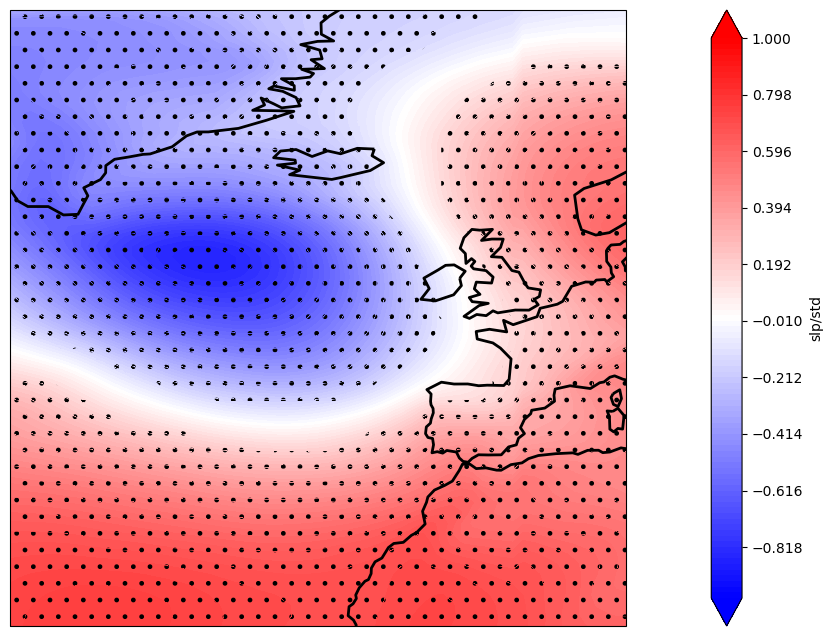

In [75]:
fig = plt.figure(figsize=(22,8)) 
dibujo_2_mapas_cartopy_hatches(RUY[:,modo],RUY_sig[:,modo],lon_y,lat_y,np.linspace(-1,1,100),'bwr', 'slp/std', 'mapa heterogéneo')